c:\Simoh\BERT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


English stopwords loaded from spaCy (326 words).
Initial data overview:
                                            question  \
0                          Is this fish fresh today?   
1  Do you mind if I go ahead of you? I only have ...   
2                     Hello, I'll take this, please.   
3  Would it be possible to order a tiered cake fo...   
4           Hello, I'd like two minced beef patties.   

                                              answer  label  
0                      Yes, it arrived this morning.      1  
1                         Yes, go ahead, no problem.      1  
2  You'll take this? Okay, so you're taking this ...      0  
3  Yes, please speak to our pastry chef; he will ...      1  
4     A red circle, a blue square, a green triangle.      0  

DataFrame dimensions: (487, 3)

Label distribution:
label
1    0.507187
0    0.492813
Name: proportion, dtype: float64

Data overview after cleaning:
                                    cleaned_question  \
0           

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training with bert-base-uncased...
--- Epoch 1/4 ---
  Train loss: 0.5031 | Train Accuracy: 0.8072
  Val. loss: 0.4828 | Val. Accuracy: 0.7959 | Val. F1 (Class 1): 0.8333
  New best model (F1 Class 1) saved with Val F1: 0.8333
--- Epoch 2/4 ---
  Train loss: 0.3353 | Train Accuracy: 0.8689
  Val. loss: 0.4346 | Val. Accuracy: 0.8061 | Val. F1 (Class 1): 0.8403
  New best model (F1 Class 1) saved with Val F1: 0.8403
--- Epoch 3/4 ---
  Train loss: 0.2541 | Train Accuracy: 0.8817
  Val. loss: 0.3740 | Val. Accuracy: 0.8061 | Val. F1 (Class 1): 0.8403
--- Epoch 4/4 ---
  Train loss: 0.2615 | Train Accuracy: 0.8329
  Val. loss: 0.3488 | Val. Accuracy: 0.8061 | Val. F1 (Class 1): 0.8403

Training finished.

Final model evaluation on the test set...
Test Loss: 0.3488 | Test Accuracy: 0.8061
Metrics for Class 1 (Coherent):
  Precision: 0.7246
  Recall:    1.0000
  F1-score:  0.8403
Metrics for Class 0 (Not Coherent):
  Precision: 1.0000
  Recall:    0.6042
  F1-score:  0.7532


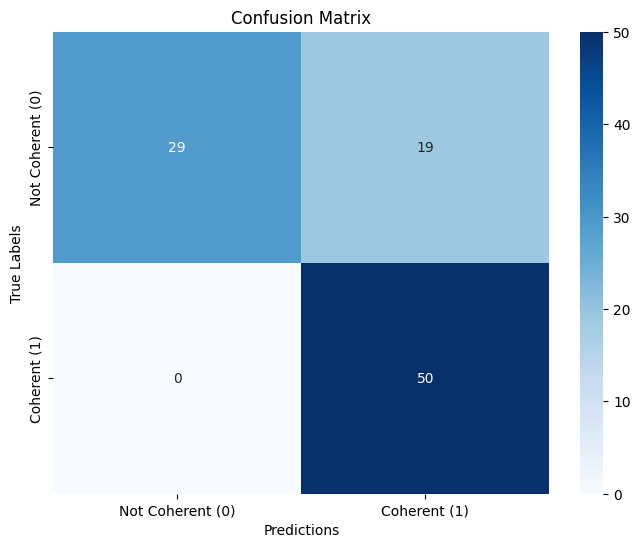

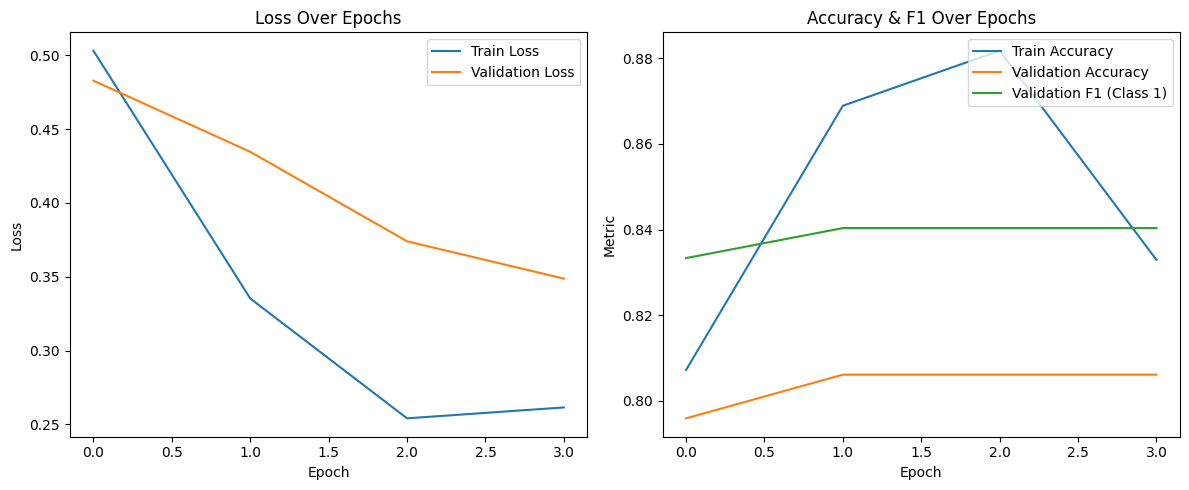


Script finished.


In [2]:
import pandas as pd
import re
import torch
from torch.utils.data import DataLoader, Dataset
# Using AutoTokenizer and AutoModelForSequenceClassification for BERT-like models
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
from torch.utils.data import WeightedRandomSampler
import numpy as np

# --- 0. Load spaCy model for English ---
try:
    nlp_en = spacy.load('en_core_web_sm')
except OSError:
    print("English spaCy model 'en_core_web_sm' not found.")
    print("Please install it with: python -m spacy download en_core_web_sm")
    # Basic English stopwords if spaCy model is not available
    stopwords_en = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "hello", "please", "thank", "thanks", "where", "can", "find", "looking", "for", "would", "like", "do", "you", "have", "know", "excuse", "me"])
    print("Using a basic list of English stopwords.")
else:
    stopwords_en = nlp_en.Defaults.stop_words
    print(f"English stopwords loaded from spaCy ({len(stopwords_en)} words).")
    # Add any custom English stopwords if needed
    # custom_stopwords_to_add_en = {"hello", "please", "thanks"}
    # stopwords_en.update(custom_stopwords_to_add_en)
    # print(f"Stopwords after adding custom words: {len(stopwords_en)} words.")


# --- 1. Load and Prepare Data ---
try:
    # Change this to your English dataset path
    df = pd.read_csv('../../data/data_train_en.csv')
except FileNotFoundError:
    print("Error: The file 'data_train_en.csv' was not found.")
    # Fictional English data for demonstration
    data_dict = {
        'question': ["Hello, where can I find the milk?", "Do you have gluten-free pasta?", "I'm looking for ground coffee", "Where are the canned tomatoes?", "Not the spice aisle."] * 247,
        'answer': ["In the dairy aisle.", "Yes, in the special products section.", "At the end of aisle 2.", "Aisle for canned goods.", "Near the baking aids."] * 247,
        'label': [1, 1, 1, 1, 1] * 100 + [0,0,0,0,0] * 147,
        'type': ['positive']*100 + ['bm25_negative']*50 + ['random_negative']*50 + ['hard_negative_semantic']*47
    }
    df = pd.DataFrame(data_dict)
    df = df.sample(frac=1).reset_index(drop=True) # Shuffle
    df = df[:1235] # Simulate a dataset size
    print("Using a fictional English DataFrame for demonstration.")

print("Initial data overview:")
print(df.head())
print(f"\nDataFrame dimensions: {df.shape}")
print(f"\nLabel distribution:\n{df['label'].value_counts(normalize=True)}")

def clean_text(text):
    text = str(text)
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    # Keep alphanumeric, spaces, and basic punctuation relevant for English
    text = re.sub(r'[^a-zA-Z0-9\s\.\?,!\']', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

df['cleaned_question'] = df['question'].apply(clean_text)
df['cleaned_answer'] = df['answer'].apply(clean_text)

print("\nData overview after cleaning:")
print(df[['cleaned_question', 'cleaned_answer', 'label']].head())

# --- 2. Prepare Data for BERT ---
# Choose an English pre-trained model
MODEL_NAME = "bert-base-uncased" # Or "roberta-base", "distilbert-base-uncased", etc.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class QACoherenceDataset(Dataset):
    def __init__(self, questions, answers, labels, tokenizer, max_len):
        self.questions = questions
        self.answers = answers
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, item):
        question = str(self.questions[item])
        answer = str(self.answers[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            question,
            answer,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True, # BERT uses token_type_ids, CamemBERT often doesn't distinguish them as much
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(), # Add if model uses them (BERT does)
            'label': torch.tensor(label, dtype=torch.long)
        }

X_questions_train, X_questions_test, \
X_answers_train, X_answers_test, \
y_train, y_test = train_test_split(
    df['cleaned_question'],
    df['cleaned_answer'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

MAX_LEN = 160 # Adjust if necessary based on your data and model
train_dataset = QACoherenceDataset(
    questions=X_questions_train.values,
    answers=X_answers_train.values,
    labels=y_train.values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
test_dataset = QACoherenceDataset(
    questions=X_questions_test.values,
    answers=X_answers_test.values,
    labels=y_test.values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

BATCH_SIZE = 16

# WeightedRandomSampler implementation (remains the same logic)
if isinstance(y_train, pd.Series):
    y_train_numpy = y_train.values
else:
    y_train_numpy = y_train

class_counts = np.bincount(y_train_numpy)
print(f"Class counts in training set: {class_counts}")

sampler = None
if len(class_counts) < 2:
    print("Warning: Only one class present in the training set. Sampler will not be effective.")
else:
    class_weights_sample = 1. / class_counts
    print(f"Inverse class frequency weights: {class_weights_sample}")
    sample_weights = np.array([class_weights_sample[label] for label in y_train_numpy])
    sample_weights_tensor = torch.from_numpy(sample_weights).double()
    sampler = WeightedRandomSampler(
        weights=sample_weights_tensor,
        num_samples=len(sample_weights_tensor),
        replacement=True
    )

if sampler:
    print("Using WeightedRandomSampler for train_loader.")
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=sampler
    )
else:
    print("WeightedRandomSampler not used, shuffle=True for train_loader.")
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# --- 3. Define Model, Optimizer, Scheduler ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model = model.to(device)

LEARNING_RATE = 2e-5
ADAM_EPSILON = 1e-8
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=ADAM_EPSILON)
total_steps = len(train_loader) * EPOCHS
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)

# --- 4. Training and Evaluation Functions ---
def train_epoch_fn(model, data_loader, optimizer, scheduler, device, n_examples):
    model.train()
    total_loss = 0
    correct_predictions = 0
    for batch_idx, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # For models like BERT that use token_type_ids
        token_type_ids = batch.get('token_type_ids') # Use .get for safety
        if token_type_ids is not None:
            token_type_ids = token_type_ids.to(device)

        optimizer.zero_grad()
        
        model_inputs = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }
        if token_type_ids is not None: # Add token_type_ids if present
            model_inputs['token_type_ids'] = token_type_ids
            
        outputs = model(**model_inputs)
        
        loss = outputs.loss
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
    return correct_predictions.double() / n_examples, total_loss / len(data_loader)

def eval_model_fn(model, data_loader, device, n_examples):
    model.eval()
    total_eval_loss = 0
    correct_predictions = 0
    all_true_labels = []
    all_pred_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            token_type_ids = batch.get('token_type_ids')
            if token_type_ids is not None:
                token_type_ids = token_type_ids.to(device)

            model_inputs = {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'labels': labels
            }
            if token_type_ids is not None:
                model_inputs['token_type_ids'] = token_type_ids

            outputs = model(**model_inputs)
            
            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_eval_loss += loss.item()
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(preds.cpu().numpy())
    avg_loss = total_eval_loss / len(data_loader)
    accuracy = correct_predictions.double() / n_examples
    return accuracy, avg_loss, all_true_labels, all_pred_labels

# --- 5. Training Loop ---
print(f"\nStarting training with {MODEL_NAME}...")
best_val_f1_minority = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1_minority': []}

for epoch in range(EPOCHS):
    print(f'--- Epoch {epoch + 1}/{EPOCHS} ---')
    train_acc, train_loss = train_epoch_fn(
        model, train_loader, optimizer, scheduler, device, len(train_dataset)
    )
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc.item()) # .item() to get Python number
    print(f'  Train loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

    val_acc, val_loss, val_true, val_pred = eval_model_fn(
        model, test_loader, device, len(test_dataset)
    )
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc.item()) # .item() to get Python number
    
    val_f1_class1 = 0.0
    if len(set(val_true)) > 1 and 1 in set(val_true):
        val_f1_class1 = f1_score(val_true, val_pred, pos_label=1, zero_division=0)
    history['val_f1_minority'].append(val_f1_class1)

    print(f'  Val. loss: {val_loss:.4f} | Val. Accuracy: {val_acc:.4f} | Val. F1 (Class 1): {val_f1_class1:.4f}')

    if val_f1_class1 > best_val_f1_minority:
        # torch.save(model.state_dict(), f'{MODEL_NAME.replace("/", "_")}_coherence_best_f1_model_epoch{epoch+1}.bin')
        best_val_f1_minority = val_f1_class1
        print(f"  New best model (F1 Class 1) saved with Val F1: {best_val_f1_minority:.4f}")

print("\nTraining finished.")

# --- 6. Final Evaluation and Detailed Metrics ---
print("\nFinal model evaluation on the test set...")
final_test_acc, final_test_loss, true_labels, pred_labels = eval_model_fn(
    model, test_loader, device, len(test_dataset)
)
print(f'Test Loss: {final_test_loss:.4f} | Test Accuracy: {final_test_acc:.4f}')

if len(set(true_labels)) > 1:
    precision_class1 = precision_score(true_labels, pred_labels, pos_label=1, zero_division=0)
    recall_class1 = recall_score(true_labels, pred_labels, pos_label=1, zero_division=0)
    f1_class1 = f1_score(true_labels, pred_labels, pos_label=1, zero_division=0)
    print(f'Metrics for Class 1 (Coherent):')
    print(f'  Precision: {precision_class1:.4f}')
    print(f'  Recall:    {recall_class1:.4f}')
    print(f'  F1-score:  {f1_class1:.4f}')

    precision_class0 = precision_score(true_labels, pred_labels, pos_label=0, zero_division=0)
    recall_class0 = recall_score(true_labels, pred_labels, pos_label=0, zero_division=0)
    f1_class0 = f1_score(true_labels, pred_labels, pos_label=0, zero_division=0)
    print(f'Metrics for Class 0 (Not Coherent):')
    print(f'  Precision: {precision_class0:.4f}')
    print(f'  Recall:    {recall_class0:.4f}')
    print(f'  F1-score:  {f1_class0:.4f}')

    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Coherent (0)', 'Coherent (1)'], yticklabels=['Not Coherent (0)', 'Coherent (1)'])
    plt.xlabel('Predictions')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("Less than two classes present in predictions/true labels on the test set.")

# Plot training history (optional)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.plot(history['val_f1_minority'], label='Validation F1 (Class 1)')
plt.title('Accuracy & F1 Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.tight_layout()
plt.show()

print("\nScript finished.")

In [3]:
# CELL TO SAVE THE MODEL AND TOKENIZER

# --- 7. Save the final trained model and tokenizer ---

# Make sure MODEL_NAME is defined from your training script
# e.g., MODEL_NAME = "bert-base-uncased"
# And device is also defined, e.g., device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a safe name for file paths from the model name
safe_model_name_for_path = MODEL_NAME.replace('/', '_') # Handles names like "org/model-name"

MODEL_SAVE_PATH_EN = f"save_model_en/{safe_model_name_for_path}_coherence_final_model.bin"
TOKENIZER_SAVE_PATH_EN = f"save_model_en/{safe_model_name_for_path}_coherence_tokenizer/" # A directory

# Ensure the save directories exist
import os
os.makedirs(os.path.dirname(MODEL_SAVE_PATH_EN), exist_ok=True)
os.makedirs(TOKENIZER_SAVE_PATH_EN, exist_ok=True)


# Ensure the model is on CPU before saving for better portability
# (Especially if you plan to load it on a machine without a GPU)
model.to('cpu')
torch.save(model.state_dict(), MODEL_SAVE_PATH_EN)
print(f"Final English model (state_dict) saved to: {MODEL_SAVE_PATH_EN}")

# Move the model back to its original device if needed for further use in this session
model.to(device) # 'device' should be defined from your training part

# Save the tokenizer (contains vocabulary, configuration, etc.)
tokenizer.save_pretrained(TOKENIZER_SAVE_PATH_EN)
print(f"English tokenizer saved to: {TOKENIZER_SAVE_PATH_EN}")

print("\nSaving complete.")

Final English model (state_dict) saved to: save_model_en/bert-base-uncased_coherence_final_model.bin
English tokenizer saved to: save_model_en/bert-base-uncased_coherence_tokenizer/

Saving complete.
